In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os


# process load time data
systems = ['dlcache', 'baseline']

data = []
for system in systems:
    for fscache in [0, 1]:
        for run in range(1, 6):
            dirs = glob.glob("{}/data/fscache={}/run{}/*".format(system, fscache, run))
            for dir in dirs:
                try:
                    compute_time = float(dir.split('/')[-1])
                    load_time = np.load('{}/load_time.npy'.format(dir))[0]
                    if os.path.exists('{}/train_cache_usage.npy'.format(dir)):
                        avg_cache_usage = np.load('{}/train_cache_usage.npy'.format(dir))
                        avg_cache_usage = np.mean(avg_cache_usage, dtype=int)
                        
                        cache_hits = 0
                        for ch in glob.glob("{}/cache_hits*".format(dir)):
                            cache_hits += np.load(ch)
                        cache_hit_rate = cache_hits / (512 * 50)
                    else:
                        avg_cache_usage = 0
                        cache_hit_rate = 0

                    data.append([system, fscache, compute_time, load_time, avg_cache_usage, cache_hit_rate])
                except:
                    pass

data = pd.DataFrame(data, columns=['system', 'fscache', 'compute_time', 'load_time', 'avg_cache_usage', 'cache_hit_rate'])
data.sort_values(by='compute_time', inplace=True)
data

,system,fscache,compute_time,load_time,avg_cache_usage,cache_hit_rate
59,dlcache,1,0.4,29.421205,4590,0.899414
29,dlcache,0,0.4,155.104018,2070,0.050469
35,dlcache,1,0.4,35.215269,4532,0.936562
41,dlcache,1,0.4,34.716853,4622,0.927148
47,dlcache,1,0.4,29.923537,4639,0.901563
...,...,...,...,...,...,...
31,dlcache,1,4.0,6.827528,4565,1.000000
91,baseline,1,4.0,6.782793,0,0.000000
85,baseline,0,4.0,203.135517,0,0.000000
67,baseline,0,4.0,201.830758,0,0.000000


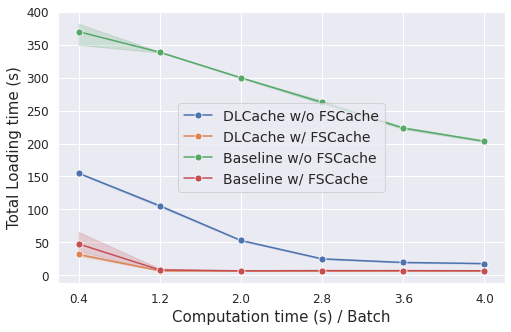

In [20]:
compute_time = data['compute_time'].unique().tolist()
sns.set(style='darkgrid',)
sns.set(rc={'figure.figsize':(8, 5)})

for system in systems:
    for fscache in [0, 1]:
        slice = data[(data['system']==system) & (data['fscache']==fscache)].sort_values(by='compute_time')
        compute_time_ticks = []
        for ct in slice['compute_time']:
            compute_time_ticks.append(compute_time.index(ct))
        slice['compute_time'] = compute_time_ticks
        if len(slice) > 0:
            if system == 'dlcache' and fscache == 0:
                label = 'DLCache w/o FSCache'
            elif system == 'dlcache' and fscache == 1:
                label = 'DLCache w/ FSCache'
            elif system == 'baseline' and fscache == 0:
                label = 'Baseline w/o FSCache'
            else:
                label = 'Baseline w/ FSCache'
                
            sns.lineplot(x='compute_time', y='load_time', data=slice, label=label, marker= '.', markersize=14)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Total Loading time (s)', fontsize = 15)
plt.legend(fontsize=14)
plt.show()

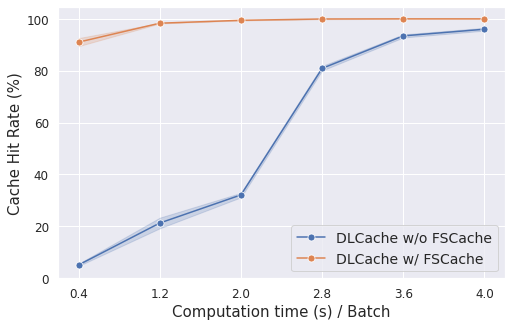

In [21]:
for fscache in [0, 1]:
    slice = data[(data['system']=='dlcache') & (data['fscache']==fscache)].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    slice['cache_hit_rate'] *= 100.0
    if len(slice) > 0:
        if fscache == 0:
            label = 'DLCache w/o FSCache'
        elif fscache == 1:
            label = 'DLCache w/ FSCache'
        sns.lineplot(x='compute_time', y='cache_hit_rate', data=slice, label=label, marker= '.', markersize=14)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Cache Hit Rate (%)', fontsize = 15)
plt.legend(fontsize=14)
plt.show()